# SVM

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
import matplotlib
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


In [2]:
seed = 22

## Loading the data

The transformations used in logistic regression were helpful as logistic regression is a linear classifier. SVM offers different kernels that can handle the non-linearily for us, so we will just use the normalized dataset.

In [3]:
train_file_norm = './processed_data/train_normed'
test_file_norm = './processed_data/test_normed'

In [4]:
train_norm = pd.read_pickle(train_file_norm)
test_norm = pd.read_pickle(test_file_norm)

In [5]:
train_norm.head()

SIZE      FUEL  DISTANCE   DESIBEL   AIRFLOW  FREQUENCY  STATUS  \
0   0.0  gasoline       0.0  0.585366  0.000000   1.000000       0   
1   0.0  gasoline       0.0  0.585366  0.000000   0.959459       1   
2   0.0  gasoline       0.0  0.585366  0.152941   0.932432       1   
3   0.0  gasoline       0.0  0.585366  0.188235   0.905405       1   
4   0.0  gasoline       0.0  0.902439  0.458824   0.878378       1   

   isGasoline  isThinner  isKerosene  isLpg  
0           1          0           0      0  
1           1          0           0      0  
2           1          0           0      0  
3           1          0           0      0  
4           1          0           0      0

### Creating a validation set

As SVM models have hyperparameters, we must carve out a validation set from the data allotted to training.

In [6]:
# the amounnt of training data to reserve for validation
val_ratio = 0.2

In [7]:
val_data = train_norm.sample(frac=val_ratio, random_state=seed)
train_data = train_norm.drop(val_data.index)

val_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

print('size of train data: {:>5}'.format(len(train_data)))
print('size of val data:   {:>5}'.format(len(val_data)))

# rename to match
test_data = test_norm

size of train data: 11163
size of val data:    2791


### Splitting into X and y for SVM

sklearn takes x and y as input separately.

In [8]:
y_train = train_data['STATUS']
X_train = train_data.drop(['STATUS', 'FUEL'], axis=1)

y_val= val_data['STATUS']
X_val = val_data.drop(['STATUS', 'FUEL'], axis=1)

y_test = test_data['STATUS']
X_test = test_data.drop(['STATUS', 'FUEL'], axis=1)

## Creating models with different kernels

### Linear Model

Sklearn SVMs always have the hyperparameter `C`. This controls the tradeoff between misclassification and simplicity. A hightly complex decision surface would be able to contour very well to the training data, but these countours may not represent the reality the training data is pulled from and will therefor likely perform poorly at test time.

Looking at the SVM documentation reveals that this parameter is coefficient on the sum of the slack variables in the minimization. It is inversely proportional to regularization strength.

$$
\underset{w, b}{\text{argmin}} \frac{1}{2} \lVert w \rVert_{2}^{2} + C \sum_{i=1}^{N}{\xi^i}
$$

We can see that higher values of C penalize slack more, meaning the model will be incentivised to increase $\lVert w \rVert_{2}^{2}$, which is cheaper that increasing the sum of $\xi^i$'s which are weighted higher by a larger `C`. The default for `C` is 1.

In [9]:
linear_svm = svm.SVC(
    kernel='linear',
    random_state=seed,
    max_iter=10000
)

In [10]:
linear_svm.fit(X_train, y_train)

SVC(kernel='linear', max_iter=10000, random_state=22)

In [11]:
linear_svm.score(X_val, y_val)

0.903977069150842

#### Tuning C on the linear model

We will tune the model on the hyperparameter `C` and evaluate the model on the validation set to find the best configuration.

As some values of `C` are imposible to train on, we must limit the iterations of the model.

In [12]:
c_values = np.logspace(-5, 5, 20)
c_values

array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])

In [13]:
validation_accuracies = []
c_values = np.logspace(-5, 5, 20)
for c in c_values:
    model =  svm.SVC(
        kernel='linear',
        random_state=seed,
        C=c,
        max_iter=100000

    )
    model.fit(X_train, y_train)
    if model:
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
    else:
        score=0
        print('model failed with c = {}'.format(c))
    validation_accuracies.append(score)


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated earl

Some models simply do not work. These throw a warning.

#### Results from broad sweep over C values

In [14]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



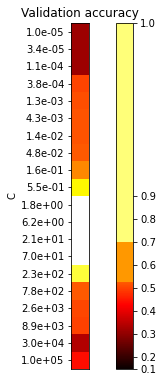

In [15]:
# process scores
scores = validation_accuracies
scores = np.array(scores).reshape(len(scores), 1)

fig = plt.figure(figsize=(10, 6))

plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    #norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
    norm=MidpointNormalize(vmin=.15, midpoint=0.9)

)

plt.ylabel("C")
plt.colorbar()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# generate new labels for the y axis so they are more readable
plt.yticks(np.arange(len(c_values)), ['{:.1e}'.format(x) for x in c_values])

plt.title("Validation accuracy")
plt.show()

This tells us that the best validation occurs with a `C` value between 0.5-23.0. We can now scan this range for the best `C`.

#### Concentrated Search for best C value

In [16]:
# generate a range of C values from 1.8 to 7 with an increment of .1
lower = 0.5
upper = 20
step = 0.1
c_values = np.arange(lower, upper, step)

best_score = 0
best_c = 0

for c in c_values:
    model =  svm.SVC(
        kernel='linear',
        random_state=seed,
        C=c
    )
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_c = c


In [17]:
print("The best score of {:.2%} was achieved with a C of {}".format(best_score, best_c))

The best score of 90.54% was achieved with a C of 1.4999999999999998


#### Results for linear model

The best performing linear model achieved an accuracy of 90.54% on the validation set with a `C` of 1.5.

### RBF Kernel models

The rbf kernel is

$$ K(x, x') = e^{-\frac{\lVert x-x' \rVert_{2}^{2}}{2 \sigma^2}} = e^{-\gamma \lVert x-x' \rVert_{2}^{2}}$$

This kernel has an infinite number of dimensions. In general, it measures similarity between points with the hyperparameter gamma.

The default gamma in sklearn is not a static number. It is calculated from the X data. The formula is `1 / (n_features * X.var())`

In [18]:
# default C of 1 and default gamma calculation
rbf_svm = svm.SVC(
    kernel='rbf',
    random_state=seed
)

In [19]:
rbf_svm.fit(X_train, y_train)

SVC(random_state=22)

In [20]:
rbf_svm.score(X_val, y_val)

0.9355069867431028

**93.55%**

The default rbf is already better than the best tuned linear model. This comes as no surprise as non-linear data transformations inproved the accuracy with the logistic regression model.

#### Broad search for best rbf model

Like before, we will look over a wide range of values for C and gamma to find what values perform best. This time, there are 2 dimensions to search through.

In [21]:
gamma_range = np.logspace(-9, 3, num=12)
c_range = np.logspace(-4, 4, num=13)

In [22]:
scores = np.zeros((len(gamma_range), len(c_range)))
for i, gamma in enumerate(gamma_range):
    for j, c in enumerate(c_range):
        model = svm.SVC(
            kernel='rbf',
            random_state=seed,
            C=c,
            gamma=gamma
        )
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        scores[i, j] = score

In [23]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

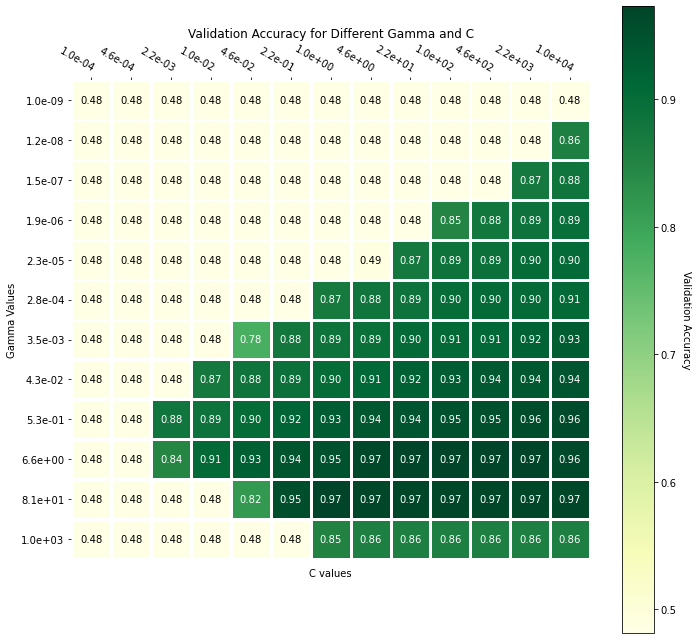

In [24]:
fig, ax = plt.subplots(figsize=(10,9))

gammas = ['{:.1e}'.format(x) for x in gamma_range]
cs = ['{:.1e}'.format(x) for x in c_range]

im, cbar = heatmap(scores, gammas, cs, ax=ax,
                   cmap="YlGn", cbarlabel="Validation Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

plt.title('Validation Accuracy for Different Gamma and C')
plt.xlabel('C values')
plt.ylabel('Gamma Values')

plt.show()

This chart shows us that the best values tend to cluster around a gamma of 7 and a `C` of 1.0e4. The first guess of the region of high performance was off--you can see that we did not sample values of `C` high enough. The C values for rbf are much higher than for linear kernel. Remember that a higher value of C means less regularization, which makes sense as the rbf kernel uses more weights to contour better to the decision boundary.

We will try again with new values of `C`.

In [25]:
gamma_range = np.logspace(-7, 6, num=15)
c_range = np.logspace(-3, 8, num=16)

In [26]:
scores = np.zeros((len(gamma_range), len(c_range)))
for i, gamma in enumerate(gamma_range):
    for j, c in enumerate(c_range):
        model = svm.SVC(
            kernel='rbf',
            random_state=seed,
            C=c,
            gamma=gamma,
            max_iter=100000

        )
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        scores[i, j] = score
    print('completed gamma = {}'.format(gamma))

completed gamma = 1e-07
completed gamma = 8.483428982440726e-07
completed gamma = 7.196856730011529e-06


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


completed gamma = 6.105402296585326e-05


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


completed gamma = 0.0005179474679231213


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated earl

completed gamma = 0.004393970560760795


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated earl

completed gamma = 0.03727593720314938


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated earl

completed gamma = 0.31622776601683794


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated earl

completed gamma = 2.6826957952797272
completed gamma = 22.75845926074791
completed gamma = 193.06977288832536
completed gamma = 1637.893706954068
completed gamma = 13894.95494373136
completed gamma = 117876.86347935867
completed gamma = 1000000.0


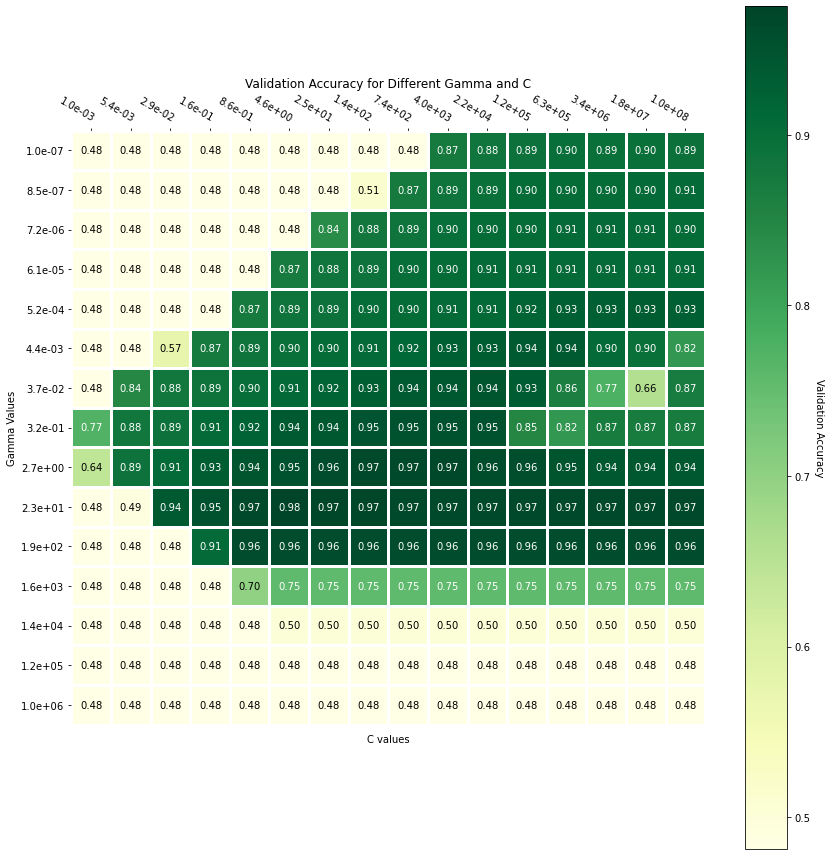

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))

gammas = ['{:.1e}'.format(x) for x in gamma_range]
cs = ['{:.1e}'.format(x) for x in c_range]

im, cbar = heatmap(scores, gammas, cs, ax=ax,
                   cmap="YlGn", cbarlabel="Validation Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

plt.title('Validation Accuracy for Different Gamma and C')
plt.xlabel('C values')
plt.ylabel('Gamma Values')

plt.show()

Still need one more go. This time focusing on gammas around 23 and C's starting at 0.

In [28]:
gamma_range = np.logspace(1, 1.6, num=7)
c_range = np.logspace(0, 3, num=10)

In [29]:
gamma_range

array([10.        , 12.58925412, 15.84893192, 19.95262315, 25.11886432,
       31.6227766 , 39.81071706])

In [30]:
c_range

array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])

In [31]:
scores = np.zeros((len(gamma_range), len(c_range)))
for i, gamma in enumerate(gamma_range):
    for j, c in enumerate(c_range):
        model = svm.SVC(
            kernel='rbf',
            random_state=seed,
            C=c,
            gamma=gamma,
            max_iter=100000
        )
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        scores[i, j] = score

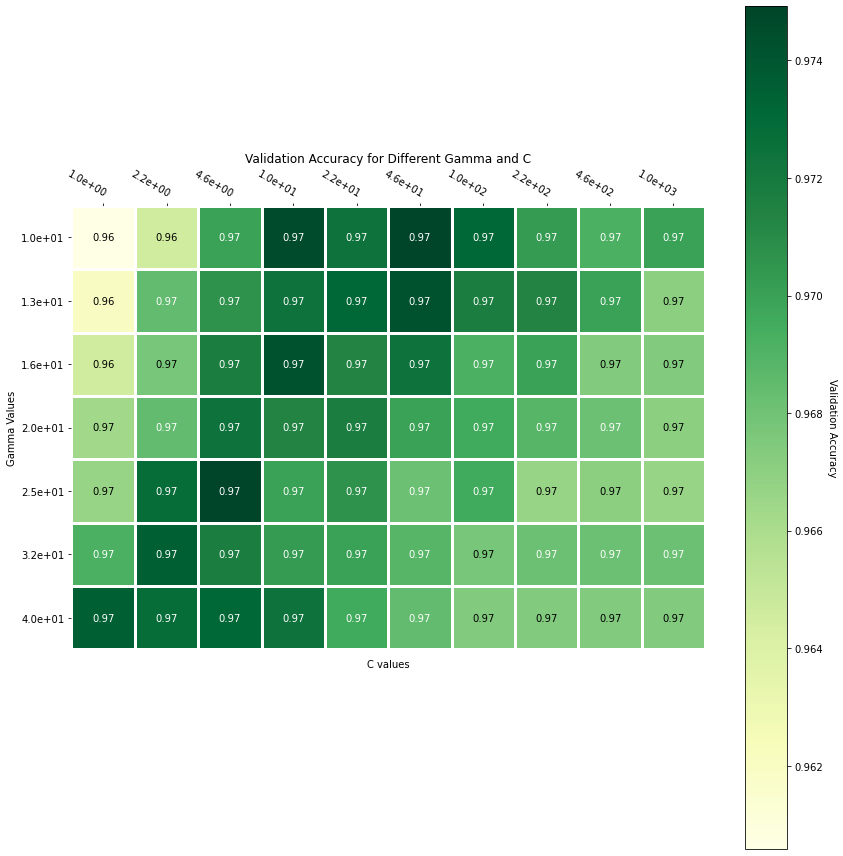

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))

gammas = ['{:.1e}'.format(x) for x in gamma_range]
cs = ['{:.1e}'.format(x) for x in c_range]

im, cbar = heatmap(scores, gammas, cs, ax=ax,
                   cmap="YlGn", cbarlabel="Validation Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

plt.title('Validation Accuracy for Different Gamma and C')
plt.xlabel('C values')
plt.ylabel('Gamma Values')

plt.show()

Now, we will look more fine grained at the area around gamma 25, C 4.6 and gamma 10, C's 1-50

In [33]:
# generate a range of C values from 1.8 to 7 with an increment of .1

best_score = 0
best_c = 0
best_gamma = 0

# first search spot
c_lower = 2
c_upper = 10
c_step = 0.25
c_values = np.arange(c_lower, c_upper, c_step)

gamma_lower = 20
gamma_upper = 30
gamma_step = 0.25
gamma_values = np.arange(gamma_lower, gamma_upper, gamma_step)


for gamma in gamma_values:
    for c in c_values:
        model = svm.SVC(
            kernel='rbf',
            random_state=seed,
            C=c,
            gamma=gamma,
            max_iter=100000
        )
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        if score > best_score:
            best_score = score
            best_c = c
            best_gamma = gamma

            
# second search spot
c_lower = 5
c_upper = 55
c_step = 2.5
c_values = np.arange(c_lower, c_upper, c_step)

gamma_lower = 5
gamma_upper = 13
gamma_step = 0.5
gamma_values = np.arange(gamma_lower, gamma_upper, gamma_step)


for gamma in gamma_values:
    for c in c_values:
        model = svm.SVC(
            kernel='rbf',
            random_state=seed,
            C=c,
            gamma=gamma,
            max_iter=100000
        )
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        if score > best_score:
            best_score = score
            best_c = c
            best_gamma = gamma
        

In [34]:
print("The best score of {:.2%} was achieved with a C of {} and a gamma of {}".format(best_score, best_c, best_gamma))

The best score of 97.60% was achieved with a C of 5.0 and a gamma of 25.75


The best score of 97.60% was achieved with a `C` of 5.0 and a gamma of 25.75

## Testing

Now that we have selected the best model based on the validation data, we can evalutate the test performance.

### Linear Model on Test Data

In [35]:
best_linear_svm =  svm.SVC(
    kernel='linear',
    random_state=seed,
    C=1.5
)

In [36]:
best_linear_svm.fit(X_train, y_train)
linear_test_score = best_linear_svm.score(X_test, y_test)

In [37]:
print("Test score of {:.2%} with a C of {}".format(linear_test_score, 1.5))

Test score of 90.05% with a C of 1.5


### RBF Model on Test Data

In [38]:
best_rbf_svm = svm.SVC(
    kernel='rbf',
    random_state=seed,
    C=5,
    gamma=25.75,
    max_iter=100000
)

In [39]:
best_rbf_svm.fit(X_train, y_train)
rbf_test_score = best_rbf_svm.score(X_test, y_test)

In [40]:
print("Test score of {:.2%} was achieved with a C of {} and a gamma of {}".format(rbf_test_score, 5, 25.75))

Test score of 96.82% was achieved with a C of 5 and a gamma of 25.75


### Default RBF Model on Test Data

In [41]:
basic_rbf = svm.SVC(
    kernel='rbf',
    random_state=seed
)

In [42]:
basic_rbf.fit(X_train, y_train)
basic_rbf_score_val = basic_rbf.score(X_val, y_val)
basic_rbf_score = basic_rbf.score(X_test, y_test)

In [43]:
print("Validation score of {:.2%} was achieved with the default rbf.".format(basic_rbf_score_val))
print("Test score of {:.2%} was achieved with the default rbf.".format(basic_rbf_score))

Validation score of 93.55% was achieved with the default rbf.
Test score of 93.35% was achieved with the default rbf.


### Results

Using the validation set, model hyperparameters were tested to create the best linear and rbf kernel SVMs.

```
Kernel: Linear
C: 1.5
```

```
Kernel: rbf
C: 5
gamma: 25.75
```

The linear kernel model achieved an accuracy of 90.05% on the test data, and the rbf kernel scored 96.82%.

The rbf kernel had a much higher value for `C` compared to the linear model. This means the model weights slack more than parameter magnitude, allowing for a more complex fit. We can see that the more complex decision boundary lead to a test set accuracy increase of 6.77%. With this more complex boundary, we risk overfitting to the training data more than when using a simpler model. We can see this difference in the validation to test accuracy drop off.

| Model  | Best Val Accuracy  |  Test Accuracy | Difference  |
|---|---|---|---|
| Best Linear  | 90.54%  | 90.05%  | -0.49%  |
| Best rbf  | 97.60%  | 96.82%  | -0.78%  |

In addition to the reason above, this bigger difference can be attributed to overfitting on the validation data by means of an exausive hyperparameter search. This is the reason why we carved out a separate validation data set. With 2 parameters to adjest to affect performance in the rbf kernel svm, we had more freedom to tune the model for best validation performance, leading to slightly more overfit on the validation data. This hyperparameter search was not pointless, however, as the tuned rbf kernel outperformed the default rbf kernel by 3.47%.

## Model Analysis

Models classify points by their position (on the + or - side) of the hyperplane. With the dual formulation for kernels, this pocess is a bit different. Classification looks at the sign of the below sum.

$$ \sum_{i \in SV}{y_i \alpha_i K(x, x') + b} $$

SV are the support vectors.

Because of this, we are only able to analyize the linear model, which can be formulated to have weights. These weights have less meaning than those from logistic regression, where they are each individually trained to produce a probability estimate. Here, they exists to define a plane that separates data.

In [44]:
w = best_linear_svm.coef_[0]
w = w.reshape(len(w), 1)
w

array([[-3.36506744],
       [-2.7646182 ],
       [ 0.97910923],
       [ 5.63381539],
       [-2.22974242],
       [-0.29063697],
       [-0.67538049],
       [-1.01699563],
       [ 1.98301308]])

In [45]:
b = best_linear_svm.intercept_
b

array([1.1968013])

In [46]:
best_linear_svm.feature_names_in_

array(['SIZE', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY',
       'isGasoline', 'isThinner', 'isKerosene', 'isLpg'], dtype=object)

In [47]:
s = .8
d = .9
db = .1
a = .3
f = .2
g = 0
t = 0
k = 0
l = 1

test_point = np.array([s, d, db, a, f, g, t, k, l])
test_point = test_point.reshape(1, len(test_point))

In [48]:
np.dot(test_point, w) + b

array([[-0.65828889]])

In [49]:
best_linear_svm.decision_function(test_point)

C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([-0.65828889])

The agreement between the manual and model predictions shows the weight extraction was correct.

As we expect, increasing distance or size of the flame makes the fire harder to put out. The features with positive weights also match our expectation. An increase in decibels or airflow makes means an increased chance at extinguishing the fire. We find that lower frequencies put out the fire with greater success too.

To our surprise, the weights on the binary features, the type of fuel, show the oposite sign as their weights in logistic regression. One hypothosis is that the hyperplane cuts the space in a way where the liquid fuel data points need a decrease to their distance moving positive from the plane. This effect exists to counter the fact that the gas fuel only comes in sizes 0 and 1, meaning the size penalty to the model's estimate that the flames will be extinguished is largely hampered.

## Resources
* matplotlib
    + https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    + https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
* SVM
    + https://scikit-learn.org/stable/modules/svm.html
    + https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
    + https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-auto-examples-svm-plot-svm-nonlinear-py
    + https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python